In [3]:
#import libsequence
import sys
import pandas as pd
import math
import argparse
import vcf
import numpy as np

In [4]:
#Function to create dictionary of polySIM summary statistics. Returns dictionary of summary stats
def get_polySIM_stats(sd):
    #Create polysim object
    ps = libsequence.PolySIM(sd)
    #Create list of methods (ie polySIM summaryStats)
    a = [method for method in dir(ps) if callable(getattr(ps, method)) if not method.startswith('_')]
    #Loop through methods, storing names as keys, and estimates as values in dict
    ss_dict = {}
    for method in a:
        ss_dict[method] = getattr(ps, method)()
        
    return(ss_dict)

In [5]:
#Function to create dictionary of LD stats. Returns dictionary.
def get_LD_stats(sd):
    ld = libsequence.ld(sd)
    df = pd.DataFrame(ld)
    ss_dict = {}
    ss_dict['meanrsq'] = sum(df['rsq'])/len(df['rsq'])
    return(ss_dict)

In [6]:
def read_fasta(FILE):
    d_SEQ = {}
    for line in FILE:
        line1 = line.strip('\n')
        if line1[0] == ">":
            s_seq_name = line1.replace(">", "")
            d_SEQ[s_seq_name] = ""
        else:
            d_SEQ[s_seq_name] = d_SEQ[s_seq_name] + line1
    return(d_SEQ)

In [7]:
def calculate_divergence(SEQ1, SEQ2, SEQ_SNPS):
    s_diff, s_tot = 0, 0
    if len(SEQ1) == len(SEQ2) and len(SEQ1) == len(SEQ_SNPS):
        for i in range(0, len(SEQ1), 1):
            if SEQ1[i] not in [".", "-", "N", "n"] and SEQ2[i] not in [".", "-", "N", "n"]:#both sequences have a known base
                if SEQ_SNPS[i] != "X" and SEQ_SNPS[i] != "N":#the site is fixed
                    s_tot += 1
                    if SEQ1[i].upper() != SEQ2[i].upper():
                        s_diff += 1
    else:
        print("check, length of sequences or SNPs is not the same")
    if s_tot == 0:
        return(np.nan)
    else:
        return(float(s_diff)/float(s_tot))

In [93]:
df = pd.read_csv(r"/home/vivak/human_demog_DFE/DFE_inference/GRCh37_exons_r_m.bed", sep='\t', header=0)
regions = list(df.region)
lengths = list(df.length)
starts = list(df.start)
ends = list(df.end)
inter_ends = list(df['end'] + (df['pi50']*4))

In [94]:
sdf = pd.DataFrame()
wdf = pd.DataFrame()
pops = {'LWK', 'EUR', 'EAS', 'SAS'}
for pop in pops:
    for i,j in enumerate(regions):
        for reg_type in ['exons', 'intergenic']:
            vcf_reader = vcf.Reader(filename=r'/home/vivak/human_demog_DFE/DFE_inference/vcf/' + pop + '/region' + str(j) + '_' + reg_type + '.vcf.gz')
            l_data = []
            for record in vcf_reader:
                l_data.append([(record.POS-starts[i])/lengths[i], ''.join([x['GT'] for x in record.samples]).replace('|','')])
            sd = libsequence.SimData(l_data)
            #ss = libsequence.PolySIM(sd)
            d = {'population': pop, 'region': j, 'region_type': reg_type}
            d = {**d, **get_polySIM_stats(sd)}
            if len(sd.pos()) >= 5: #LD stats are pairwise. If only 1 site exists, it'll show an error.
                d = {**d, **get_LD_stats(sd)}
            else:
                d['meanrsq'] = 'NA'
            df2 = pd.DataFrame.from_dict(d, orient='index').T
            df2 = df2[['population', 'region', 'region_type', 'numpoly','numsingletons', 'thetapi', 'tajimasd', 'meanrsq']]
            for stat in ['numpoly','numsingletons', 'thetapi']:
                df2[stat] = df2[stat] / lengths[i]
            sdf = pd.concat([sdf, df2])

In [95]:
res = []
pops = {'LWK', 'EUR', 'EAS', 'SAS'}
for pop in pops:
    for i,j in enumerate(regions):
        reg_type = 'exons'
        f_anc = open("/home/vivak/human_demog_DFE/DFE_inference/fasta/region" + str(j) + "_" + reg_type + ".fasta", 'r')
        f_hg19 = open("/home/vivak/human_demog_DFE/DFE_inference/fasta/ancestral/region" + str(j) + "_" + reg_type + ".fasta", 'r')
        f_snp = open("/home/vivak/human_demog_DFE/DFE_inference/fasta/snp_masked/" + pop + "/region" + str(j) + "_" + reg_type + ".fasta", 'r')
        d_anc = read_fasta(f_anc)
        d_hg19 = read_fasta(f_hg19)
        d_snp = read_fasta(f_snp)
        div = calculate_divergence(list(d_anc.values())[0], list(d_hg19.values())[0], list(d_snp.values())[0])
        
        reg_type = 'intergenic'
        f_anc = open("/home/vivak/human_demog_DFE/DFE_inference/fasta/region" + str(j) + "_" + reg_type + ".fasta", 'r')
        f_hg19 = open("/home/vivak/human_demog_DFE/DFE_inference/fasta/ancestral/region" + str(j) + "_" + reg_type + ".fasta", 'r')
        f_snp = open("/home/vivak/human_demog_DFE/DFE_inference/fasta/snp_masked/" + pop + "/region" + str(j) + "_" + reg_type + ".fasta", 'r')
        d_anc = read_fasta(f_anc)
        d_hg19 = read_fasta(f_hg19)
        d_snp = read_fasta(f_snp)
        div2 = calculate_divergence(list(d_anc.values())[0], list(d_hg19.values())[0], list(d_snp.values())[0])
        if(div2>0):
            d_ratio = div / div2
        else:
            d_ratio = np.nan
        
        res.append([pop, j, div, div2, d_ratio])

ddf = pd.DataFrame(res, columns=['population', 'region', 'exonic_divergence', 'intergenic_divergence', 'divergence_ratio'])
ddf.to_csv(r"/home/vivak/human_demog_DFE/DFE_inference/empirical_summary_stats/empirical_divergence.txt", header=True, index=False, sep='\t')

In [98]:
edf = sdf[sdf.population=='LWK']
edf = edf.drop(columns='population')
edf.columns = ['region', 'region_type', 'S_AFR', 'singletons_AFR', 'pi_AFR', 'tajimasd_AFR', 'meanrsq_AFR']

for pop in ['EUR', 'EAS', 'SAS']:
    tdf = sdf[sdf.population==pop]
    tdf = tdf.drop(columns='population')
    tdf.columns = ['region' , 'region_type', 'S_'+pop, 'singletons_'+pop, 'pi_'+pop, 'tajimasd_'+pop, 'meanrsq_'+pop]
    edf = pd.merge(edf, tdf, on=['region', 'region_type'], how='inner')

In [100]:
fdf = pd.read_csv(r"/home/vivak/human_demog_DFE/DFE_inference/empirical_summary_stats/empirical_Fst.txt", sep='\t', 
           names=['populations', 'region', 'region_type', 'Fst'])

In [101]:
edf3 = fdf[fdf['populations']=='LWK_EUR']
edf3 = edf3.drop(columns=['populations'])
edf3.columns = ['region', 'region_type', 'Fst_AFR_EUR']

pops = {'LWK_EAS':'AFR_EAS', 'LWK_SAS':'AFR_SAS', 'EAS_EUR': 'EUR_EAS', 'SAS_EUR': 'EUR_SAS', 'EAS_SAS': 'EAS_SAS'}
for pop in pops:
    tdf = fdf[fdf['populations']==pop]
    tdf = tdf.drop(columns=['populations'])
    tdf.columns = ['region', 'region_type', 'Fst_' + pops[pop]]
    edf3 = pd.merge(edf3, tdf, on=['region', 'region_type'], how='inner')

In [102]:
df = pd.merge(edf, edf3, on=['region', 'region_type'], how='inner')
df.to_csv(r"/home/vivak/human_demog_DFE/DFE_inference/empirical_summary_stats/empirical_summary_stats_final.txt", header=True, index=False, sep='\t')

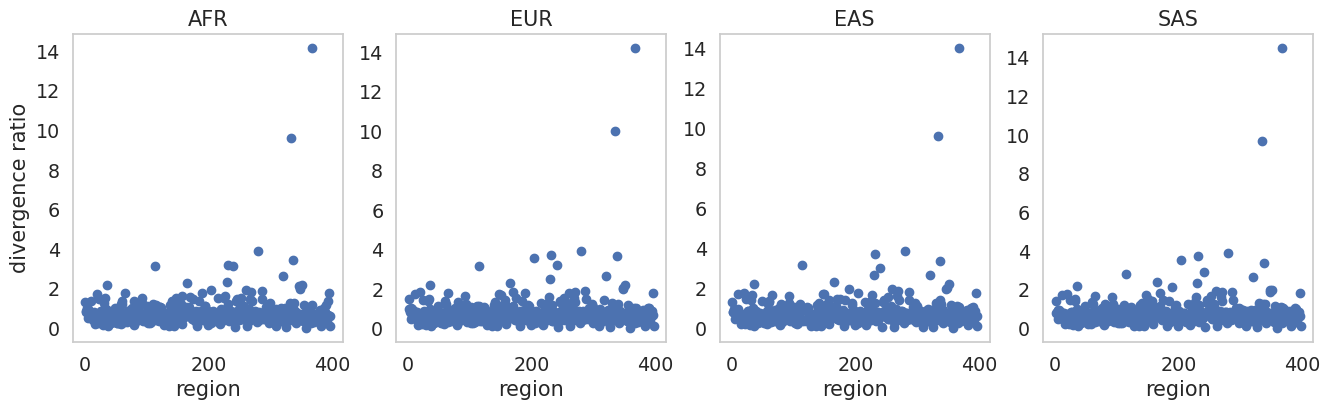

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
ddf = pd.read_csv(r"/home/vivak/human_demog_DFE/DFE_inference/empirical_summary_stats/empirical_divergence.txt", header=0, sep='\t')
ddf['population'] = np.where(ddf.population=='LWK', 'AFR', ddf.population)
sns.set(rc={'figure.figsize':(16, 4),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.25)
for i,pop in enumerate(['AFR','EUR','EAS','SAS']):
    plt.subplot(1,4,i+1)
    tdf = ddf[ddf.population==pop]
    plt.scatter(tdf.region, tdf.divergence_ratio)  
    if(pop=='AFR'):
        plt.ylabel('divergence ratio')
    plt.xlabel('region')
    plt.title(pop)
plt.subplots_adjust(wspace=0.2, hspace=0.6)

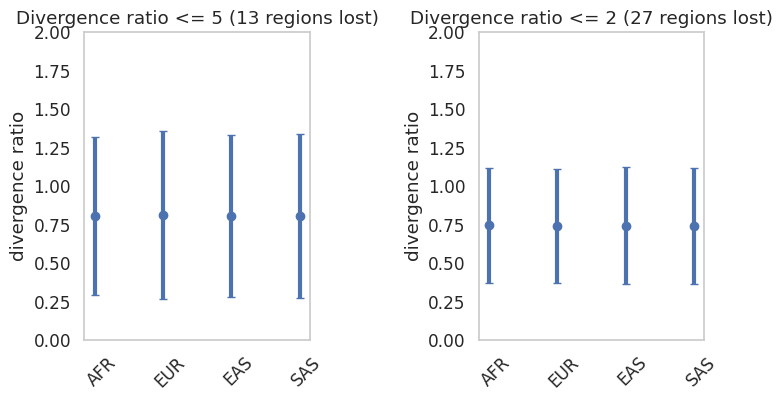

In [46]:
pops = ['AFR','EUR','EAS','SAS']
sns.set(rc={'figure.figsize':(8,4),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.1)
plt.subplot(1,2,1)
edf = ddf[ddf.divergence_ratio<5.01]
x = np.arange(4) 
for j,pop in enumerate(pops):
    plt.errorbar([j-0.1], edf[edf.population==pop].divergence_ratio.mean(), edf[edf.population==pop].divergence_ratio.std(),
                    fmt='o', lw=3, capsize=3, zorder=15, c='b') 
    plt.xticks(x, pops, rotation=45)
plt.title('Divergence ratio <= 5 (13 regions lost)')
plt.ylabel('divergence ratio')
plt.ylim([0,2])

plt.subplot(1,2,2)
edf = ddf[ddf.divergence_ratio<2.01]
x = np.arange(4) 
for j,pop in enumerate(pops):
    plt.errorbar([j-0.1], edf[edf.population==pop].divergence_ratio.mean(), edf[edf.population==pop].divergence_ratio.std(),
                    fmt='o', lw=3, capsize=3, zorder=15, c='b') 
    plt.xticks(x, pops, rotation=45)
plt.title('Divergence ratio <= 2 (27 regions lost)')
plt.ylabel('divergence ratio')
plt.ylim([0,2])
plt.subplots_adjust(wspace=0.75, hspace=0.6)

In [47]:
df = pd.read_csv(r"/home/vivak/human_demog_DFE/DFE_inference/GRCh37_exons_r_m.bed", header=0, sep='\t')

In [51]:
ddf[ddf.population=='AFR'].exonic_divergence.describe()

count    395.000000
mean       0.004024
std        0.003171
min        0.000000
25%        0.002330
50%        0.003588
75%        0.004927
max        0.038072
Name: exonic_divergence, dtype: float64

In [52]:
ddf[ddf.population=='AFR'].intergenic_divergence.describe()

count    393.000000
mean       0.005423
std        0.003456
min        0.000000
25%        0.003637
50%        0.004904
75%        0.006451
max        0.031915
Name: intergenic_divergence, dtype: float64